In [57]:
import random
import glob
import pandas as pd
import seaborn as sns

### Phase 1

In [58]:
# glob.glob('*.csv')

In [59]:
# paths = list(filter(lambda x: 'cendol-mt5' in x, glob.glob('*.csv')))
# random.shuffle(paths)

# dfs = []
# for path in paths:
#     print(path)
#     df = pd.read_csv(path)
#     df = df.sample(30, random_state=14045)
#     print(df.index)
#     dfs.append(df)
# pd.concat(dfs).to_csv('human_eval_arxiv.csv', index=False)

In [60]:
# paths

In [61]:
# ['cendol-mt5-xxl-merged_v2.csv',
#  'cendol-mt5-large_v1.csv',
#  'cendol-mt5-base_v1.csv',
#  'cendol-mt5-xxl-merged_v1.csv',
#  'cendol-mt5-xl_v2.csv',
#  'cendol-mt5-xl_v1.csv',
#  'cendol-mt5-small_v1.csv',
#  'cendol-mt5-large_v2.csv',
#  'cendol-mt5-base_v2.csv',
#  'cendol-mt5-small_v2.csv']

### Phase 2

In [62]:
# paths = list(filter(lambda x: 'cendol-mt5' not in x and 'human' not in x, glob.glob('*.csv')))
# random.shuffle(paths)

# dfs = []
# print("PATHS ---", paths)
# for path in paths:
#     # print(path)
#     df = pd.read_csv(path, on_bad_lines='skip')
#     print(path, df.columns)
#     df['responses'] = df['responses'].fillna('').apply(lambda x: x.replace('<s>', '').replace('</s>', '').strip())
#     df = df.sample(30, random_state=14045)
#     print(df.index)
#     dfs.append(df)
# pd.concat(dfs).to_csv('human_eval_arxiv_p2.csv', index=False)

In [63]:
# paths

In [64]:
# ['baseline_bloomz-7b1.csv',
#  'baseline_Llama-2-7b-chat-hf.csv',
#  'baseline_SeaLLM-7B-Chat.csv',
#  'cendol-llama2-7b_v1.csv',
#  'baseline_Merak-7B-v4.csv',
#  'baseline_sealion7b-instruct-nc.csv',
#  'baseline_Llama-2-13b-chat-hf.csv',
#  'baseline_bactrian-id-bloom-7b1-lora.csv',
#  'cendol-llama2-13b-merged-chat_v2.csv',
#  'baseline_bactrian-x-bloom-7b1-lora.csv',
#  'cendol-llama2-13b-merged_v1.csv',
#  'cendol-llama2-7b-chat_v2.csv']

# Human Recap

In [65]:
hdf = pd.read_csv('human_eval/human_eval_phase_1.csv')
models = []
for m in [
    'cendol-mt5-xxl_v2',
    'cendol-mt5-large_v1',
    'cendol-mt5-base_v1',
    'cendol-mt5-xxl_v1',
    'cendol-mt5-xl_v2',
    'cendol-mt5-xl_v1',
    'cendol-mt5-small_v1',
    'cendol-mt5-large_v2',
    'cendol-mt5-base_v2',
    'cendol-mt5-small_v2'
]:
    models += [m] * 30
hdf['model'] = models
hdf = hdf.reset_index()

In [66]:
rdfs = []
for i, r in enumerate(['R1', 'R2', 'R3']):
    rdf = hdf[['index', 'model', r]]
    rdf = rdf.rename({r: 'score'}, axis='columns')
    rdf.loc[:,'annot_id'] = i
    rdfs.append(rdf)
df = pd.concat(rdfs)

### Analysis

In [67]:
from agreement.utils.transform import pivot_table_frequency

questions_answers_table = pivot_table_frequency(df.loc[:,'index'], df.loc[:,'score'])
users_answers_table = pivot_table_frequency(df.loc[:,'annot_id'], df.loc[:,'score'])

In [68]:
from agreement.utils.kernels import linear_kernel
from agreement.metrics import cohens_kappa, krippendorffs_alpha

kappa = cohens_kappa(questions_answers_table, users_answers_table)
weighted_kappa = cohens_kappa(questions_answers_table, users_answers_table, weights_kernel=linear_kernel)

alpha = krippendorffs_alpha(questions_answers_table)

In [69]:
kappa, weighted_kappa, alpha

(0.47542727294703496, 0.5882149496346892, 0.47457202572693663)

In [70]:
def get_model_id(model_name):
    if 'small' in model_name:
        return 0
    if 'base' in model_name:
        return 1
    if 'large' in model_name:
        return 2
    if 'xl' in model_name:
        return 3
    if 'xxl' in model_name:
        return 4

pdf = df.groupby(['model', 'score']).size().reset_index().pivot(index='model', columns='score', values=0).fillna(0).reset_index()
pdf['model_id'] = pdf['model'].apply(get_model_id)

In [71]:
def get_model_name(mdl):
    return mdl[7:].split('_')[0]

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

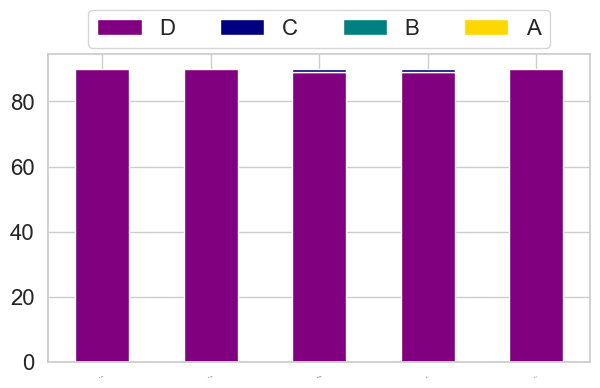

In [72]:
plt.rcParams["figure.figsize"] = (7,4)

v1_df = pdf.sort_values('model_id').loc[pdf['model'].str.contains('v1'), ['model', 'D', 'C', 'B','A']]
v1_df.plot(kind='bar', stacked=True, color=['purple','navy','teal','gold'])
plt.xticks([0, 1, 2, 3, 4], v1_df['model'].apply(get_model_name), fontsize=0, rotation=12)
plt.yticks(fontsize=16)
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5,1.18), fontsize=16)
# plt.savefig('v1_eval.pdf', bbox_anchor='tight')
plt.show()

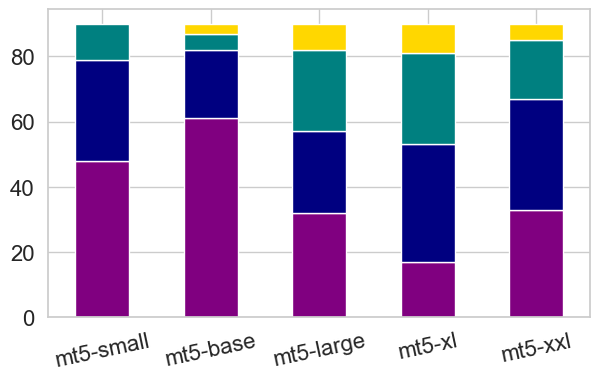

In [73]:
plt.rcParams["figure.figsize"] = (7,4)

v2_df = pdf.sort_values('model_id').loc[pdf['model'].str.contains('v2'), ['model', 'D', 'C', 'B','A']]
ax = v2_df.plot(kind='bar', stacked=True, color=['purple','navy','teal','gold'])
ax.legend().set_visible(False)
plt.xticks([0, 1, 2, 3, 4], v2_df['model'].apply(get_model_name), fontsize=16, rotation=12)
plt.yticks(fontsize=16)
# plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5,1.15), fontsize=12)
# plt.savefig('v2_eval.pdf', bbox_anchor='tight')
plt.show()

# Human Recap v2

In [74]:
hdf = pd.concat([
    pd.read_csv('human_eval/human_eval_phase_1.csv'),
    pd.read_csv('human_eval/human_eval_phase_2.csv')
])

models = []
for m in [
    'cendol-mt5-xxl_v2',
    'cendol-mt5-large_v1',
    'cendol-mt5-base_v1',
    'cendol-mt5-xxl_v1',
    'cendol-mt5-xl_v2',
    'cendol-mt5-xl_v1',
    'cendol-mt5-small_v1',
    'cendol-mt5-large_v2',
    'cendol-mt5-base_v2',
    'cendol-mt5-small_v2',
    'baseline_bloomz-7b1',
    'baseline_Llama-2-7b-chat-hf',
    'baseline_SeaLLM-7B-Chat',
    'cendol-llama2-7b_v1',
    'baseline_Merak-7B-v4',
    'baseline_sealion7b-instruct-nc',
    'baseline_Llama-2-13b-chat-hf',
    'baseline_bactrian-id-bloom-7b1-lora',
    'cendol-llama2-13b-merged-chat_v2',
    'baseline_bactrian-x-bloom-7b1-lora',
    'cendol-llama2-13b-merged_v1',
    'cendol-llama2-7b-chat_v2'
]:
    models += [m] * 30
hdf['model'] = models
hdf = hdf.reset_index()

In [75]:
rdfs = []
for i, r in enumerate(['R1', 'R2', 'R3']):
    rdf = hdf[['index', 'model', r]]
    rdf.loc[:,r] = rdf.loc[:,r].str.upper()
    rdf = rdf.rename({r: 'score'}, axis='columns')
    rdf.loc[:,'annot_id'] = i
    rdfs.append(rdf)
df = pd.concat(rdfs)

### Analysis

In [76]:
def get_model_id(model_name):
    if 'baseline' in model_name:
        return -1
    if 'small' in model_name:
        return 0
    if 'base' in model_name:
        return 1
    if 'large' in model_name:
        return 2
    if 'xxl' in model_name:
        return 4
    if 'xl' in model_name:
        return 3
    if '7b' in model_name:
        return 5
    if '13b' in model_name:
        return 6
    

pdf = df.groupby(['model', 'score']).size().reset_index().pivot(index='model', columns='score', values=0).fillna(0).reset_index()
pdf['model_id'] = pdf['model'].apply(get_model_id)

In [77]:
pdf['A'] = pdf['A'].apply(lambda x: x/90)
pdf['B'] = pdf['B'].apply(lambda x: x/90)
pdf['C'] = pdf['C'].apply(lambda x: x*-1/90)
pdf['D'] = pdf['D'].apply(lambda x: x*-1/90)

In [78]:
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [79]:
model_to_index = {
    'baseline_Llama-2-7b-chat-hf': 0,
    'baseline_Llama-2-13b-chat-hf': 1,
    'baseline_bactrian-x-bloom-7b1-lora': 2,
    'baseline_sealion7b-instruct-nc': 3,
    'baseline_SeaLLM-7B-Chat': 4,
    'baseline_bactrian-id-bloom-7b1-lora': 5,
    'baseline_Merak-7B-v4': 6,
    'cendol-mt5-xl_v1': 7,
    'cendol-mt5-xxl_v1': 8,
    'cendol-llama2-7b_v1': 9,
    'cendol-llama2-13b-merged_v1': 10,
    'cendol-mt5-xl_v2': 11,
    'cendol-mt5-xxl_v2': 12,
    'cendol-llama2-7b-chat_v2': 13,
    'cendol-llama2-13b-merged-chat_v2': 14,
}
    
model_to_display_name = {
    'baseline_Llama-2-7b-chat-hf': 'LLaMA2\n7B Chat',
    'baseline_Llama-2-13b-chat-hf': 'LLaMA2\n13B Chat',
    'baseline_bactrian-x-bloom-7b1-lora': 'Bactrian-X',
    'baseline_sealion7b-instruct-nc': 'SEALION\n7B Instruct',
    'baseline_SeaLLM-7B-Chat': 'SeaLLM\n7B Chat',
    'baseline_bactrian-id-bloom-7b1-lora': 'Bactrian-Id',
    'baseline_Merak-7B-v4': 'Merak\n7B v4',
    'cendol-mt5-small_v1': 'Cendol\nmT5 Small',
    'cendol-mt5-base_v1': 'Cendol\nmT5 Base',
    'cendol-mt5-large_v1': 'Cendol\nmT5 Large',
    'cendol-mt5-xl_v1': 'Cendol\nmT5 XL',
    'cendol-mt5-xxl_v1': 'Cendol\nmT5 XXL',
    'cendol-llama2-7b_v1': 'Cendol\nLLaMA2 7B',
    'cendol-llama2-13b-merged_v1': 'Cendol\nLLaMA2 13B',
    'cendol-mt5-small_v2': 'Cendol mT5\nSmall Chat',
    'cendol-mt5-base_v2': 'Cendol mT5\nBase Chat',
    'cendol-mt5-large_v2': 'Cendol mT5\nLarge Chat',
    'cendol-mt5-xl_v2': 'Cendol mT5\nXL Chat',
    'cendol-mt5-xxl_v2': 'Cendol mT5\nXXL Chat',
    'cendol-llama2-7b-chat_v2': 'Cendol LLaMA2\n7B Chat',
    'cendol-llama2-13b-merged-chat_v2': 'Cendol LLaMA2\n13B Chat'
}

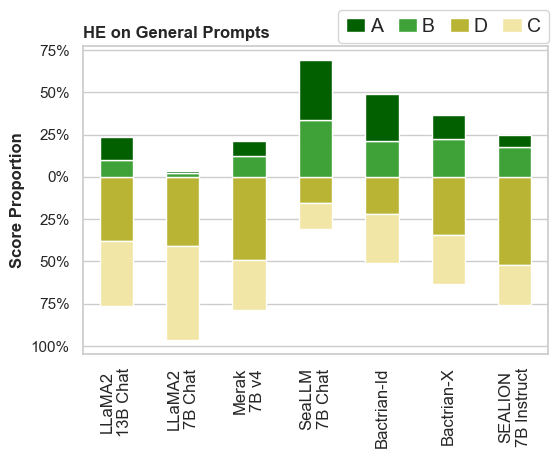

In [80]:
###
# Appendix Baseline Local Prompt
###

sns.set_theme(style="whitegrid", palette=None)

def get_model_name(mdl):
    return mdl.split('_')[1]

baseline_df = pdf.sort_values('model_id').loc[(pdf['model'].str.contains('baseline')) & (~pdf['model'].str.contains('bloomz')), ['model', 'D', 'C', 'B','A']]

ax = baseline_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(6,4),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(baseline_df['model'].nunique())], baseline_df['model'].apply(lambda x: model_to_display_name[x]), fontsize=12, rotation=90)
# plt.yticks(fontsize=0)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.775, 1.15), fontsize=14)
plt.ylabel("Score Proportion", fontweight="bold", fontsize=12)
plt.title("HE on General Prompts", loc="left", fontweight="bold")
plt.savefig('local_prompt_baseline_eval.pdf', bbox_inches='tight')
plt.show()

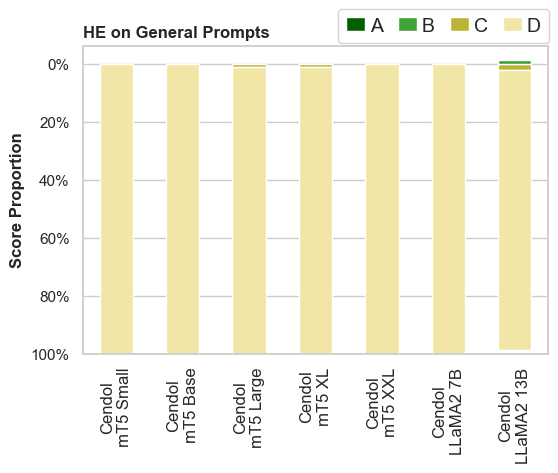

In [81]:
###
# Appendix V1 Local Prompt
###

sns.set_theme(style="whitegrid", palette=None)

def get_model_name(mdl):
    return '-'.join(mdl.split('cendol-')[1:])

v1_df = pdf.sort_values('model_id').loc[pdf['model'].str.contains('v1'), ['model', 'C', 'D', 'B','A']]

ax = v1_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(6,4),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(v1_df['model'].nunique())], v1_df['model'].apply(lambda x: model_to_display_name[x]), fontsize=12, rotation=90)
# plt.yticks(fontsize=0)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.775, 1.15), fontsize=14)
plt.ylabel("Score Proportion", fontweight="bold", fontsize=12)
plt.title("HE on General Prompts", loc="left", fontweight="bold")
plt.savefig('local_prompt_v1_eval.pdf', bbox_inches='tight')
plt.show()

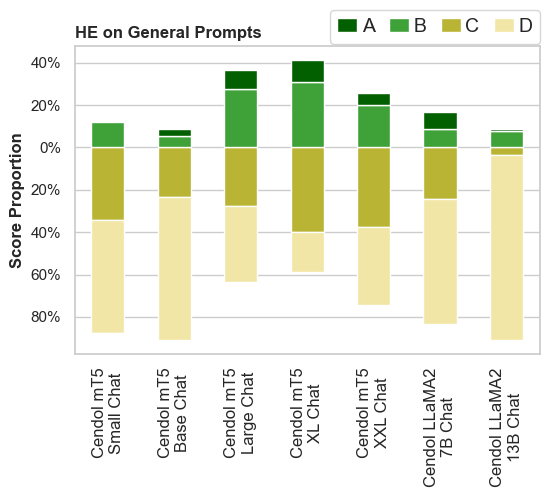

In [82]:
###
# Appendix V2 Local Prompt
###

sns.set_theme(style="whitegrid", palette=None)

def get_model_name(mdl):
    return '-'.join(mdl.split('cendol-')[1:])

v2_df = pdf.sort_values('model_id').loc[pdf['model'].str.contains('v2'), ['model', 'C', 'D', 'B','A']]

ax = v2_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(6,4),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(v2_df['model'].nunique())], v2_df['model'].apply(lambda x: model_to_display_name[x]), fontsize=12, rotation=90)
# plt.yticks(fontsize=0)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.775, 1.15), fontsize=14)
plt.ylabel("Score Proportion", fontweight="bold", fontsize=12)
plt.title("HE on General Prompts", loc="left", fontweight="bold")
plt.savefig('local_prompt_v2_eval.pdf', bbox_inches='tight')
plt.show()

In [83]:
ppdf = pdf.loc[(pdf['model_id'].isin([-1,3,4,5,6])) & (pdf['model'] != 'baseline_bloomz-7b1')]
ppdf['model_id'] = ppdf['model'].apply(lambda x: model_to_index[x])
all_df = ppdf.sort_values('model_id').loc[:, ['model', 'C', 'D', 'B','A']]

/var/folders/pj/68jfz6h56l73wpjh3rm5v_rr0000gn/T/ipykernel_25991/654414282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppdf['model_id'] = ppdf['model'].apply(lambda x: model_to_index[x])


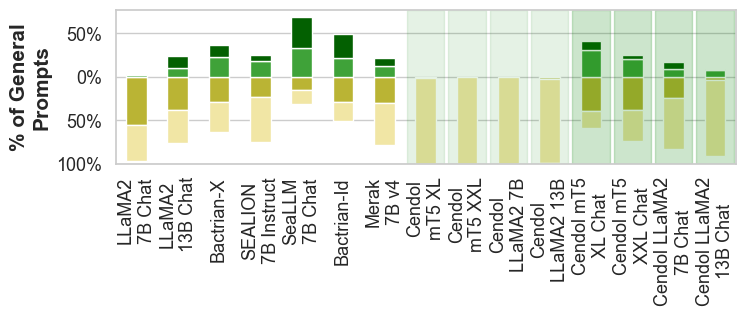

In [85]:
###
# Main Result Local Prompt
###
sns.set_theme(style="whitegrid", palette=None)

def get_model_name(mdl):
    if 'baseline' in mdl:
        return mdl.split('_')[1]
    else:
        return mdl.replace('chat', '').replace('_v2', '-chat').replace('_v1', '-instruct')

# plt.rcParams["figure.figsize"] = (12,4)

all_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            legend=False,
            figsize=(8,2),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(all_df['model'].nunique())], all_df['model'].apply(lambda x: model_to_display_name[x]), fontsize=13, rotation=90)
plt.yticks(fontsize=13)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(
#     [handles[-1], handles[-2], handles[0], handles[1]],
#     [labels[-1], labels[-2], labels[0], labels[1]],
#     handlelength=2, columnspacing=1, handletextpad=0.5,
#     ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=16)
n_model = len(all_df)
for i in range(n_model-8, n_model-4):
    plt.axvspan(i-0.45,i+0.45, color='green', alpha=0.1)
for i in range(n_model-4, n_model):
    plt.axvspan(i-0.45,i+0.45, color='green', alpha=0.2)
plt.ylabel("% of General\nPrompts", fontweight="bold", fontsize=15, loc="center")
# plt.title("Human Eval. on General Prompts", loc="left", fontweight="bold", fontsize=16)
plt.savefig('local_prompt_all_eval.pdf', bbox_inches='tight')
plt.show()

# Task Specific

In [29]:
model_to_index = {
    'bloomz-560m': 0,
    'bloomz-1b1': 1,
    'bloomz-1b7': 2,
    'bloomz-3b': 3,
    'bloomz-7b1': 4,
    'mt0-small': 5,
    'mt0-base': 6,
    'mt0-large': 7,
    'mt0-xl': 8,
    'mt0-xxl': 9,
    'Llama-2-7b-chat-hf': 10,
    'Llama-2-13b-chat-hf': 11, 
    'bactrian-x-bloom-7b1-lora': 12,
    'sealion7b-instruct-nc': 13, 
    'SeaLLM-7B-Chat': 14,
    'bactrian-id-bloom-7b1-lora': 15,
    'Merak-7B-v4': 16,
    'cendol-mt5-small': 20,
    'cendol-mt5-base': 21,
    'cendol-mt5-large': 22,
    'cendol-mt5-xl': 23,
    'cendol-mt5-xxl-merged': 24,
    'cendol-llama2-7b': 25,
    'cendol-llama2-13b-merged': 26,
    'cendol-mt5-small-chat': 27,
    'cendol-mt5-base-chat': 28,
    'cendol-mt5-large-chat': 29,
    'cendol-mt5-xl-chat': 30,
    'cendol-mt5-xxl-merged-chat': 31,
    'cendol-llama2-7b-chat': 32,
    'cendol-llama2-13b-merged-chat': 33
}

model_to_display_name = {
    'bloomz-560m': 'BLOOMZ\n560M',
    'bloomz-1b1': 'BLOOMZ\n1.1B',
    'bloomz-1b7': 'BLOOMZ\n1.7B',
    'bloomz-3b': 'BLOOMZ\n3B',
    'bloomz-7b1': 'BLOOMZ\n7.1B',
    'mt0-small': 'mT0\nSmall',
    'mt0-base': 'mT0\nBase',
    'mt0-large': 'mT0\nLarge',
    'mt0-xl': 'mT0\nXL',
    'mt0-xxl': 'mT0\nXXL',
    'bactrian-x-bloom-7b1-lora': 'Bactrian-X',
    'bactrian-id-bloom-7b1-lora': 'Bactrian-Id',
    'Llama-2-7b-chat-hf': 'LLaMA2\n7B Chat', 
    'Llama-2-13b-chat-hf': 'LLaMA2\n13B Chat', 
    'sealion7b-instruct-nc': 'SEALION\n7B Instruct', 
    'SeaLLM-7B-Chat': 'SeaLLM\n7B Chat',
    'Merak-7B-v4': 'Merak\n7B v4',
    'cendol-mt5-small': 'Cendol\nmT5 Small',
    'cendol-mt5-base': 'Cendol\nmT5 Base',
    'cendol-mt5-large': 'Cendol\nmT5 Large',
    'cendol-mt5-xl': 'Cendol\nmT5 XL',
    'cendol-mt5-xxl-merged': 'Cendol\nmT5 XXL',
    'cendol-llama2-7b': 'Cendol\nLLaMA2 7B',
    'cendol-llama2-13b-merged': 'Cendol\nLLaMA2 13B',
    'cendol-mt5-small-chat': 'Cendol mT5\nSmall Chat',
    'cendol-mt5-base-chat': 'Cendol mT5\nBase Chat',
    'cendol-mt5-large-chat': 'Cendol mT5\nLarge Chat',
    'cendol-mt5-xl-chat': 'Cendol mT5\nXL Chat',
    'cendol-mt5-xxl-merged-chat': 'Cendol mT5\nXXL Chat',
    'cendol-llama2-7b-chat': 'Cendol LLaMA2\n7B Chat',
    'cendol-llama2-13b-merged-chat':'Cendol LLaMA2\n13B Chat'
}

model_to_color = {
    'bloomz-560m': 'gray',
    'bloomz-1b1': 'gray',
    'bloomz-1b7': 'gray',
    'bloomz-3b': 'gray',
    'bloomz-7b1': 'gray',
    'mt0-small': 'g',
    'mt0-base': 'g',
    'mt0-large': 'g',
    'mt0-xl': 'g',
    'mt0-xxl': 'g',
    'bactrian-x-bloom-7b1-lora': 'b',
    'bactrian-id-bloom-7b1-lora': 'b',
    'Llama-2-13b-chat-hf': 'purple', 
    'Llama-2-7b-chat-hf': 'purple', 
    'sealion7b-instruct-nc': 'orange',
    'SeaLLM-7B-Chat': 'orange',
    'Merak-7B-v4': 'yellow',
    'cendol-mt5-small': 'r',
    'cendol-mt5-base': 'r',
    'cendol-mt5-large': 'r',
    'cendol-mt5-xl': 'r',
    'cendol-mt5-xxl-merged': 'r',
    'cendol-llama2-7b': 'pink',
    'cendol-llama2-13b-merged': 'pink',
    'cendol-mt5-small-chat': 'r',
    'cendol-mt5-base-chat': 'r',
    'cendol-mt5-large-chat': 'r',
    'cendol-mt5-xl-chat': 'r',
    'cendol-mt5-xxl-merged-chat': 'r',
    'cendol-llama2-7b-chat': 'pink',
    'cendol-llama2-13b-merged-chat': 'pink'
}

### Ind

In [30]:
ind_eval_df = pd.read_csv('human_eval/human_eval_task_ind.csv')

In [31]:
m_ind_eval_df = ind_eval_df.melt(id_vars=['Model'], value_vars=['R1', 'R2', 'R3'])
m_ind_eval_df['model_id'] = m_ind_eval_df['Model'].apply(lambda x: model_to_index[x])

In [32]:
pdf = m_ind_eval_df.groupby(['model_id', 'Model', 'value']).size().reset_index()

In [33]:
pdf = pdf.pivot(index=['model_id', 'Model'], columns='value', values=0).reset_index()

In [34]:
# plt.rcParams["figure.figsize"] = (10,4)
# all_df = pdf.sort_values('model_id').loc[:, ['Model', 'D', 'C', 'B','A']]
# all_df.plot(kind='bar', stacked=True, color=['purple','navy','teal','gold'])
# plt.xticks([i for i in range(all_df['Model'].nunique())], all_df['Model'].apply(get_model_name), fontsize=12, rotation=90)
# plt.yticks(fontsize=16)
# plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5,1.18), fontsize=16)
# # plt.savefig('v1_eval.pdf', bbox_anchor='tight')
# plt.show()

In [35]:
ind_pdf = pdf.copy()

### Local

In [36]:
sun_eval_df = pd.read_csv('human_eval/human_eval_task_sun.csv')
jav_eval_df = pd.read_csv('human_eval/human_eval_task_jav.csv')
min_eval_df = pd.read_csv('human_eval/human_eval_task_min.csv')

In [37]:
local_df = pd.concat([
    sun_eval_df, jav_eval_df, min_eval_df
])

In [38]:
pdf = local_df.groupby(['Model', 'R1']).size().reset_index()
pdf['model_id'] = pdf['Model'].apply(lambda x: model_to_index[x])

In [39]:
pdf = pdf.pivot(index=['model_id', 'Model'], columns='R1', values=0).reset_index()

In [40]:
local_pdf = pdf.copy()

In [41]:
pdf = pd.concat([
    ind_pdf, local_pdf
])

In [42]:
pdf = pdf.groupby(['model_id', 'Model'])[['A', 'B', 'C', 'D']].sum().reset_index()
pdf['A'] = pdf['A'].apply(lambda x: x/180)
pdf['B'] = pdf['B'].apply(lambda x: x/180)
pdf['C'] = pdf['C'].apply(lambda x: x*-1/180)
pdf['D'] = pdf['D'].apply(lambda x: x*-1/180)

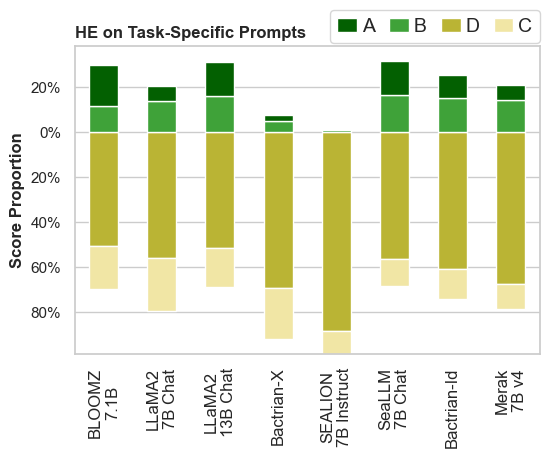

In [43]:
###
# Appendix Baseline Task-Specific
###

sns.set_theme(style="whitegrid", palette=None)

all_df = pdf.loc[pdf['model_id'] < 20].sort_values('model_id').loc[:, ['Model', 'D', 'C', 'B','A']]

ax = all_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(6,4),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(all_df['Model'].nunique())], all_df['Model'].apply(lambda x: model_to_display_name[x]), fontsize=12, rotation=90)
# plt.yticks(fontsize=0)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.775, 1.15), fontsize=14)
plt.ylabel("Score Proportion", fontweight="bold", fontsize=12)
plt.title("HE on Task-Specific Prompts", loc="left", fontweight="bold")
plt.savefig('task_prompt_baseline_eval.pdf', bbox_inches='tight')
plt.show()

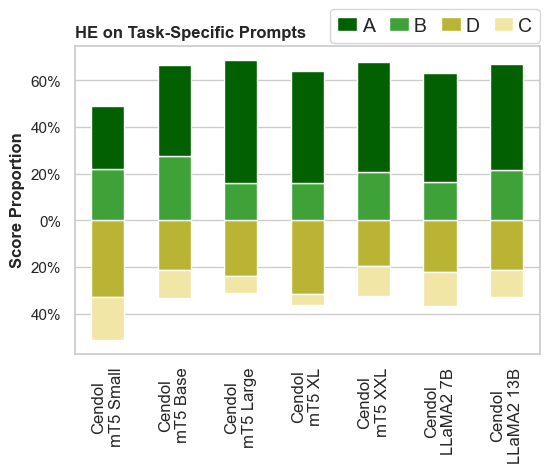

In [44]:
###
# Appendix V1 Task-Specific
###

sns.set_theme(style="whitegrid", palette=None)

all_df = pdf.loc[(20 <= pdf['model_id']) & (pdf['model_id'] <= 26)].sort_values('model_id').loc[:, ['Model', 'D', 'C', 'B','A']]

ax = all_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(6,4),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(all_df['Model'].nunique())], all_df['Model'].apply(lambda x: model_to_display_name[x]), fontsize=12, rotation=90)
# plt.yticks(fontsize=0)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.775, 1.15), fontsize=14)
plt.ylabel("Score Proportion", fontweight="bold", fontsize=12)
plt.title("HE on Task-Specific Prompts", loc="left", fontweight="bold")
plt.savefig('task_prompt_v1_eval.pdf', bbox_inches='tight')
plt.show()

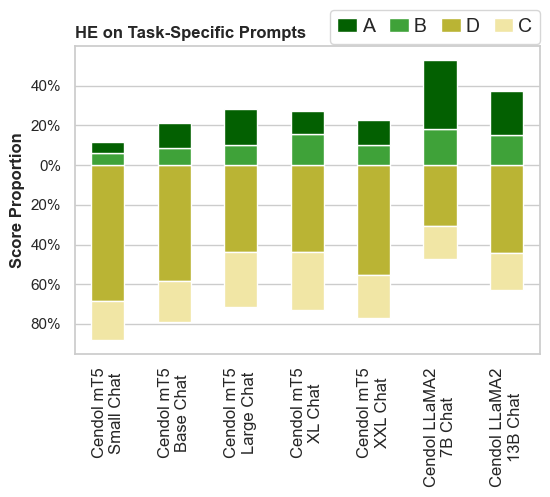

In [45]:
###
# Appendix V2 Task-Specific
###

sns.set_theme(style="whitegrid", palette=None)

all_df = pdf.loc[(26 < pdf['model_id'])].sort_values('model_id').loc[:, ['Model', 'D', 'C', 'B','A']]

ax = all_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(6,4),
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(all_df['Model'].nunique())], all_df['Model'].apply(lambda x: model_to_display_name[x]), fontsize=12, rotation=90)
# plt.yticks(fontsize=0)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.775, 1.15), fontsize=14)
plt.ylabel("Score Proportion", fontweight="bold", fontsize=12)
plt.title("HE on Task-Specific Prompts", loc="left", fontweight="bold")
plt.savefig('task_prompt_v2_eval.pdf', bbox_inches='tight')
plt.show()

In [46]:
pdf = pdf.loc[pdf['model_id'].isin([10,11,12,13,14,15,16,23,24,25,26,30,31,32,33])]

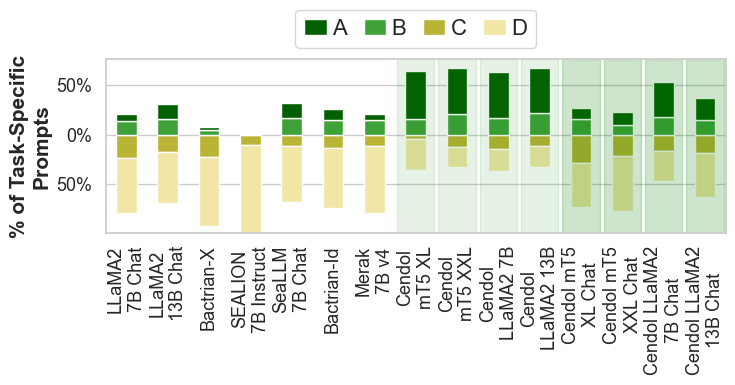

In [56]:
###
# Main Result Task-Specific
###
sns.set_theme(style="whitegrid", palette=None)

def get_model_name(mdl):
    if 'baseline' in mdl:
        return mdl.split('_')[1]
    else:
        return mdl.replace('-merged', '').replace('_v1', '-instruct')

# plt.rcParams["figure.figsize"] = (12,4)

all_df = pdf.sort_values('model_id').loc[:, ['Model', 'C', 'D', 'B', 'A']]
all_df.plot(kind='bar',
            stacked=True,
            # grid=False,
            figsize=(8,2.25),
            # legend=None,
            # title="EEHEHEHE",
            color=['#bab434ff','#f1e6a5ff','#3fa239ff','#036001ff']).grid(axis='x')

# sns.barplot(data=all_pdf, x="Model", y="score_value", hue="score") #, order="score")

plt.xticks([i for i in range(all_df['Model'].nunique())], all_df['Model'].apply(lambda x: model_to_display_name[x]), fontsize=13, rotation=90)
plt.yticks(fontsize=13)

from matplotlib.ticker import FuncFormatter

@FuncFormatter
def my_formatter(x, pos):
     return "{}".format(str(int(round(abs(x) * 100))) + "%")
plt.gca().yaxis.set_major_formatter(my_formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    [handles[-1], handles[-2], handles[0], handles[1]],
    [labels[-1], labels[-2], labels[0], labels[1]],
    handlelength=1, columnspacing=0.75, handletextpad=0.25,
    ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=16)
n_model = len(all_df)
for i in range(n_model-8, n_model-4):
    plt.axvspan(i-0.45,i+0.45, color='green', alpha=0.1)
for i in range(n_model-4, n_model):
    plt.axvspan(i-0.45,i+0.45, color='green', alpha=0.2)
plt.ylabel("% of Task-Specific\nPrompts", fontweight="bold", fontsize=15, loc="center")
# plt.title("Human Eval. on Task-Specific Prompts", loc="left", fontweight="bold", fontsize=16)
plt.savefig('task_prompt_all_eval.pdf', bbox_inches='tight')
plt.show()